# Classification models

This notebook shows classification model training and evaluation using features derived from remote sensing time series in the previous notebooks. In this case, we make use of h2o python package to achieve model training and classification in shorter time frames via h2o processing in Java. 

## Machine learning with h2o.ai

First we import the h2o python package and initialize the H2O cluster with a memory limit of 8GB.

In [1]:
import h2o
import os

In [27]:
# Initialize h2o cluster
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/azalazar/anaconda3/envs/models3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpzmma9o19
  JVM stdout: /tmp/tmpzmma9o19/h2o_azalazar_started_from_python.out
  JVM stderr: /tmp/tmpzmma9o19/h2o_azalazar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Bogota
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,5 months and 7 days !!!
H2O cluster name:,H2O_from_python_azalazar_23frpg
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


### Data ingestion

In the previous prepare dataset norbeooks, the multi-dimensional labeled arrays stored as netCDF files are transformed to dataframes and serialized to parquet format files via dask, xarray and pandas. The parquet files can be read directly as h2o data frames.

In [3]:
data = h2o.import_file(os.environ['WIN_SVR_DATA']+'Saldana/parquet77/')

Parse progress: |█████████████████████████████████████████████████████████| 100%


We specify the features to be used on the models. The ground truth class is in the *vclass*, while the feature names are indicated as the combination of *band*, *derivative* and *relative time*. Considering two vegetation indices, radar backscattering for VV polarization and 9 GLCM texture variable time series and their first derivative, and 8 times, we get 192 predictor variables.

In [62]:
y = 'vclass'

x = []

for band in ['NDVI','LSWI','VV']:#,'VV_ASM','VV_Contrast','VV_Dissimilarity','VV_Energy','VV_Entropy',
             #'VV_GLCMCorrelation','VV_GLCMMean', 'VV_GLCMVariance', 'VV_Homogeneity']:
    for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
        x.append(band+time)

print('{} predictor variables in x'.format(len(x)))

24 predictor variables in x


In [63]:
x

['NDVI_0',
 'NDVI_16',
 'NDVI_n16',
 'NDVI_n32',
 'NDVI_n48',
 'NDVI_n64',
 'NDVI_n80',
 'NDVI_n96',
 'LSWI_0',
 'LSWI_16',
 'LSWI_n16',
 'LSWI_n32',
 'LSWI_n48',
 'LSWI_n64',
 'LSWI_n80',
 'LSWI_n96',
 'VV_0',
 'VV_16',
 'VV_n16',
 'VV_n32',
 'VV_n48',
 'VV_n64',
 'VV_n80',
 'VV_n96']

In [4]:
# Change classification type is a factor
data['vclass'] = data['vclass'].asfactor()
# Verify factor levels
data['vclass'].levels()

[['1', '2', '3', '4', '5']]

In [5]:
# Split train and test datasets
train = data[data['tt']=='train']
print('Number of train pixels: {}'.format(train.shape[0]))
test = data[data['tt']=='test']
print('Number of test pixels: {}'.format(test.shape[0]))

Number of train pixels: 13723
Number of test pixels: 9786


### Model initialization

In [66]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_model = H2ORandomForestEstimator(model_id='rf_mod', ntrees=200, seed=1)

### Model training

In [67]:
rf_model.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [68]:
# Visualize model details incl. training scores
rf_model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_mod


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.0005277831965658146
RMSE: 0.022973532522575075
LogLoss: 0.005335441285692484
Mean Per-Class Error: 0.0002127659574468085
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
3767.0,0.0,0.0,0.0,0.0,0.0,"0 / 3,767"
0.0,2174.0,0.0,0.0,0.0,0.0,"0 / 2,174"
0.0,2.0,1878.0,0.0,0.0,0.0010638,"2 / 1,880"
0.0,0.0,0.0,3665.0,0.0,0.0,"0 / 3,665"
0.0,0.0,0.0,0.0,2237.0,0.0,"0 / 2,237"
3767.0,2176.0,1878.0,3665.0,2237.0,0.0001457,"2 / 13,723"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9998543
2,1.0
3,1.0
4,1.0
5,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
,2018-08-08 15:05:45,0.014 sec,0.0,nan,nan,nan
,2018-08-08 15:05:45,0.106 sec,1.0,0.0493260,0.0764375,0.0021947
,2018-08-08 15:05:45,0.173 sec,2.0,0.0719599,0.1531267,0.0053366
,2018-08-08 15:05:45,0.228 sec,3.0,0.0639555,0.1146300,0.0043273
,2018-08-08 15:05:45,0.287 sec,4.0,0.0648730,0.1091808,0.0044530
---,---,---,---,---,---,---
,2018-08-08 15:05:49,3.869 sec,60.0,0.0255698,0.0053993,0.0000729
,2018-08-08 15:05:49,3.930 sec,61.0,0.0253514,0.0053584,0.0000729
,2018-08-08 15:05:49,3.995 sec,62.0,0.0255275,0.0054142,0.0000729
,2018-08-08 15:05:53,8.036 sec,139.0,0.0234350,0.0052663,0.0002186



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NDVI_0,289652.8125000,1.0,0.1769236
NDVI_n16,147644.9062500,0.5097306,0.0901834
NDVI_n64,137538.4843750,0.4748391,0.0840103
NDVI_n32,121625.5546875,0.4199012,0.0742904
LSWI_0,121456.3828125,0.4193171,0.0741871
---,---,---,---
VV_n96,9487.1611328,0.0327536,0.0057949
VV_n16,6459.7939453,0.0223019,0.0039457
VV_0,6412.0346680,0.0221370,0.0039166
VV_n32,6247.7192383,0.0215697,0.0038162



See the whole table with table.as_data_frame()


### Model evaluation

In [69]:
rf_perf = rf_model.model_performance(test)
rf_perf


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.13920324254288519
RMSE: 0.3730995075618369
LogLoss: 0.43288634691285627
Mean Per-Class Error: 0.06172761900909374
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
1379.0,119.0,0.0,95.0,0.0,0.1343377,"214 / 1,593"
35.0,541.0,0.0,0.0,0.0,0.0607639,35 / 576
0.0,0.0,2217.0,1.0,0.0,0.0004509,"1 / 2,218"
0.0,0.0,314.0,2745.0,36.0,0.1130856,"350 / 3,095"
0.0,0.0,0.0,0.0,2304.0,0.0,"0 / 2,304"
1414.0,660.0,2531.0,2841.0,2340.0,0.0613121,"600 / 9,786"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9386879
2,0.9912119
3,0.9979563
4,0.9998978
5,1.0


In [70]:
rf_perf.confusion_matrix().as_data_frame()

,1,2,3,4,5,Error,Rate
0,1379.0,119.0,0.0,95.0,0.0,0.134338,"214 / 1,593"
1,35.0,541.0,0.0,0.0,0.0,0.060764,35 / 576
2,0.0,0.0,2217.0,1.0,0.0,0.000451,"1 / 2,218"
3,0.0,0.0,314.0,2745.0,36.0,0.113086,"350 / 3,095"
4,0.0,0.0,0.0,0.0,2304.0,0.000000,"0 / 2,304"
5,1414.0,660.0,2531.0,2841.0,2340.0,0.061312,"600 / 9,786"


In [71]:
from sklearn.metrics import cohen_kappa_score

classification = rf_model.predict(test)['predict'].as_data_frame().values
ground_truth = test['vclass'].as_data_frame().values

cohen_kappa_score(classification, ground_truth)

drf prediction progress: |████████████████████████████████████████████████| 100%


0.9199346790468922

### Visualize classification

In [20]:
import xarray as xr
import numpy as np
import pandas as pd

# Join original test dataset and prediction as pandas dataframe
resulting_class_df = test.as_data_frame().join(rf_model.predict(test)['predict'].as_data_frame())
# Set pandas MultiIndex from variables to be coordinates
resulting_class_df.set_index(['time','x', 'y'], inplace=True)
# Return to xarray and keep only ground truth and prediction
xarr = xr.Dataset.from_dataframe(resulting_class_df).sortby('time')[['vclass','predict']]
# Convert time to np.datetime64
xarr['time'] = np.array([np.datetime64(pd.to_datetime(i, unit='us')) for i in xarr.time.values],
                        dtype=np.datetime64)
# Visualize array
xarr

drf prediction progress: |████████████████████████████████████████████████| 100%


<xarray.Dataset>
Dimensions:  (time: 3, x: 369, y: 295)
Coordinates:
  * time     (time) datetime64[us] 2015-11-27 2015-12-21 2016-01-07
  * y        (y) int64 425045 425055 425065 425075 425085 425095 425105 ...
  * x        (x) int64 499455 499465 499475 499485 499495 499505 499515 ...
Data variables:
    vclass   (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    predict  (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...

In [21]:
## Create a method to visualize classifications

import matplotlib.pyplot as plt
from datetime import datetime

def compare_predictions(xarr):
    
    data_to_plot = []
    tags = []
    
    times = xarr.time.values
    
    for date in [0,1,2]:
        predicted = xarr.isel(time=date)['predict']
        test = xarr.isel(time=date)['vclass']
        data_to_plot += [test, predicted]
        tags += ['ground_truth '+str(times[date])[:10], 'classified '+str(times[date])[:10]]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=False, sharey=False)
    for idx, ax in enumerate(axes.flat):
        im = ax.imshow(data_to_plot[idx],cmap='viridis',vmin=1,vmax=5,extent=[0.05,0.5,1,0.05],aspect=0.5)
        ax.set_title(tags[idx])
        
    fig.subplots_adjust(right=0.8)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    

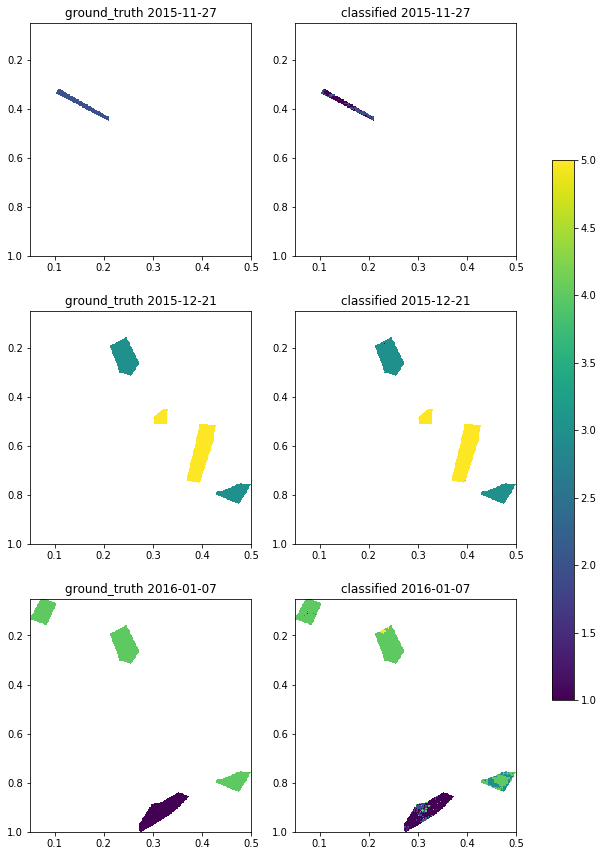

In [22]:
compare_predictions(xarr)

In [77]:
performances_idx_opt_dyn

[89.98827323365582,
 91.37469314885071,
 87.83529813770716,
 88.48448687350835,
 83.22595230021477,
 93.8780287955051,
 96.10668301655426,
 95.77383694150161,
 91.3253364540667]

## Evaluate PCA for number of features reduction

In [9]:
from h2o.transforms.decomposition import H2OPCA

pca_decomp = H2OPCA(k=5, transform="Normalize", pca_method="Randomized")

In [10]:
pca_in = []

for band in ['VV', 'VV_ASM','VV_Contrast','VV_Dissimilarity','VV_Energy','VV_Entropy',
             'VV_GLCMCorrelation','VV_GLCMMean', 'VV_GLCMVariance', 'VV_Homogeneity']:
    for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
        pca_in.append(band+time)

pca_decomp.train(x=pca_in, training_frame=train)

pca Model Build progress: |███████████████████████████████████████████████| 100%


/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


In [11]:
pca = pca_decomp.predict(train)
pca

pca prediction progress: |████████████████████████████████████████████████| 100%


PC1,PC2,PC3,PC4,PC5
0.677655,-0.652975,-0.635978,-0.0396511,-0.680439
1.04114,-0.0732995,-0.255472,-0.0145579,-0.265154
0.526017,0.111692,-0.478997,-0.0972112,-0.230372
-0.83453,-0.166141,-0.532808,0.666974,-0.287741
-0.559648,-0.165388,-0.278192,0.50558,-0.141509
-1.03998,-0.43539,0.514649,-0.413076,-0.144622
-1.11656,-0.595919,-0.0585248,-0.319733,-0.00064835
-1.12899,-0.445998,0.302785,-0.451194,-0.0411013
-1.09889,-0.415281,0.441927,-0.366412,-0.102405
-1.2258,-0.454175,0.490449,-0.238746,-0.182565


In [12]:
pca_train = train.cbind(pca)

In [13]:
pca_x = ['PC1','PC2','PC3','PC4','PC5']

for band in ['NDVI','LSWI','VV']:
    for der in ['','_1der']:
        for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
            pca_x.append(band+time)

print(pca_x)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'NDVI_0', 'NDVI_16', 'NDVI_n16', 'NDVI_n32', 'NDVI_n48', 'NDVI_n64', 'NDVI_n80', 'NDVI_n96', 'NDVI_0', 'NDVI_16', 'NDVI_n16', 'NDVI_n32', 'NDVI_n48', 'NDVI_n64', 'NDVI_n80', 'NDVI_n96', 'LSWI_0', 'LSWI_16', 'LSWI_n16', 'LSWI_n32', 'LSWI_n48', 'LSWI_n64', 'LSWI_n80', 'LSWI_n96', 'LSWI_0', 'LSWI_16', 'LSWI_n16', 'LSWI_n32', 'LSWI_n48', 'LSWI_n64', 'LSWI_n80', 'LSWI_n96', 'VV_0', 'VV_16', 'VV_n16', 'VV_n32', 'VV_n48', 'VV_n64', 'VV_n80', 'VV_n96', 'VV_0', 'VV_16', 'VV_n16', 'VV_n32', 'VV_n48', 'VV_n64', 'VV_n80', 'VV_n96']


In [14]:
pca_test = test.cbind(pca_decomp.predict(test))

pca prediction progress: |████████████████████████████████████████████████| 100%


## Evaluate train/test splits

As data availability is very limited, we evaluate the stability of the model results, given different configuration of the dataset splitting into train and test datasets. This split is done at polygon level to avoid using correlated pixels from the same field in both train and test dataframes. 

The results show that there is still a high variability in the models performance (~20%) in the different split configurations.

In [18]:
y = 'vclass'
x_opt_stat = ['NDVI_0','LSWI_0']
x_opt_dyn = []
x_opt_vv_dyn = []
x_opt_vv_glcm_dyn = []
x_opt_dyn_pca = ['PC1','PC2','PC3','PC4','PC5']

for band in ['NDVI','LSWI']:
    for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
        x_opt_dyn.append(band+time)
        x_opt_dyn_pca.append(band+time)

for band in ['NDVI','LSWI','VV']:
    for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
        x_opt_vv_dyn.append(band+time)

for band in ['NDVI','LSWI','VV','VV_ASM','VV_Contrast','VV_Dissimilarity','VV_Energy','VV_Entropy',
             'VV_GLCMCorrelation','VV_GLCMMean', 'VV_GLCMVariance', 'VV_Homogeneity']:
    for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
        x_opt_vv_glcm_dyn.append(band+time)
        

In [20]:
from sklearn.metrics import cohen_kappa_score
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.transforms.decomposition import H2OPCA

#Only including NDVI+LSWI at time0
performances_idx_opt_stat = {'oa':[],'kappa':[]}
#Incld NDVI+LSWI time-series features
performances_idx_opt_dyn = {'oa':[],'kappa':[]}
#Incld NDVI+LSWI+VV time-series
performances_idx_opt_vv_dyn = {'oa':[],'kappa':[]}
#Incld NDVI+LSWI+VV+GLCM time-series
performances_idx_opt_vv_glcm_dyn = {'oa':[],'kappa':[]}
#Incld NDVI+LSWI+PCA time-series
performances_idx_opt_dyn_pca = {'oa':[],'kappa':[]}

for seed in [11,22,33,44,55,66,77,88,99]:
    
    #Read data
    data = h2o.import_file(os.environ['WIN_SVR_DATA']+'Saldana/parquet'+str(seed)+'/')
    data['vclass'] = data['vclass'].asfactor()
    #Split
    train = data[data['tt']=='train']
    test = data[data['tt']=='test']
    
    #Fit model 1
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=x_opt_stat, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_stat['oa'].append(perf)
    performances_idx_opt_stat['kappa'].append(cohen_kappa_score(rf_fit.predict(test)['predict'].as_data_frame().values,
                                                                test['vclass'].as_data_frame().values))
    
    
    #Fit model 2
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=x_opt_dyn, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_dyn['oa'].append(perf)
    performances_idx_opt_dyn['kappa'].append(cohen_kappa_score(rf_fit.predict(test)['predict'].as_data_frame().values,
                                                                test['vclass'].as_data_frame().values))
    
    #Fit model 3
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=x_opt_vv_dyn, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_vv_dyn['oa'].append(perf)
    performances_idx_opt_vv_dyn['kappa'].append(cohen_kappa_score(rf_fit.predict(test)['predict'].as_data_frame().values,
                                                                test['vclass'].as_data_frame().values))
    
    #Fit model 4
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=x_opt_vv_glcm_dyn, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_vv_glcm_dyn['oa'].append(perf)
    performances_idx_opt_vv_glcm_dyn['kappa'].append(cohen_kappa_score(rf_fit.predict(test)['predict'].as_data_frame().values,
                                                                test['vclass'].as_data_frame().values))
    
    #Fit model 5
    
    pca_decomp = H2OPCA(k=5, transform="Normalize", pca_method="Randomized")
    pca_decomp.train(x=pca_in, training_frame=train)
    
    pca_train = train.cbind(pca_decomp.predict(train))
    pca_test = test.cbind(pca_decomp.predict(test))
    
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=x_opt_dyn_pca, y=y, training_frame=pca_train)
    perf = (rf_fit.predict(pca_test)['predict']==pca_test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_dyn_pca['oa'].append(perf)
    performances_idx_opt_dyn_pca['kappa'].append(cohen_kappa_score(rf_fit.predict(pca_test)['predict'].as_data_frame().values,
                                                                test['vclass'].as_data_frame().values))
    

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |██

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


pca prediction progress: |████████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |█

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
pca Model Build progress: |█

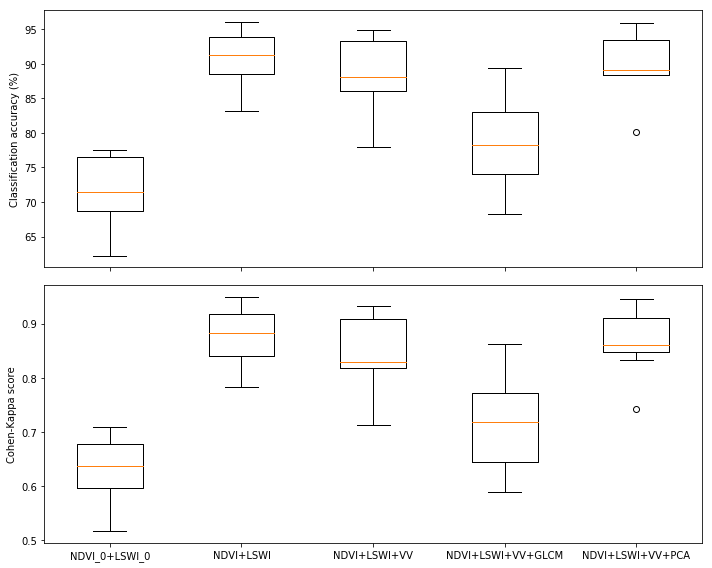

In [24]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10, 8), sharex=True)

data_dict = [performances_idx_opt_stat, performances_idx_opt_dyn, performances_idx_opt_vv_dyn,
            performances_idx_opt_vv_glcm_dyn, performances_idx_opt_dyn_pca]

ax[0].boxplot(list(map(lambda x: x['oa'], data_dict)))

#ax[0].set_xticklabels(['NDVI_0+LSWI_0','NDVI+LSWI','NDVI+LSWI+VV',
#                    'NDVI+LSWI+VV+GLCM','NDVI+LSWI+VV+PCA'])

ax[0].set_ylabel('Classification accuracy (%)')


ax[1].boxplot(list(map(lambda x: x['kappa'], data_dict)))

ax[1].set_xticklabels(['NDVI_0+LSWI_0','NDVI+LSWI','NDVI+LSWI+VV',
                    'NDVI+LSWI+VV+GLCM','NDVI+LSWI+VV+PCA'])

ax[1].set_ylabel('Cohen-Kappa score')

plt.tight_layout()

plt.show()

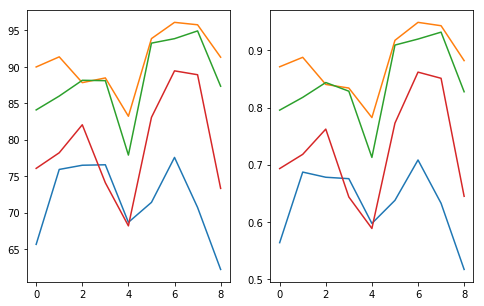

In [44]:
fig, ax = plt.subplots(1,2, figsize=(8, 5), sharey=False)

for x in range(0,4):
    ax[0].plot(data_dict[x]['oa'])
    
for x in range(0,4):
    ax[1].plot(data_dict[x]['kappa'])

## Other model configurations

In [31]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_v1 = H2ORandomForestEstimator(model_id="rf_covType_v1", ntrees=500, stopping_rounds=2,
                                 score_each_iteration=True, seed=100)

rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=200, seed=1)

In [196]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='misclassification',     #used for early stopping
                                        #stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

In [161]:
# Import H2O DL <to test>
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [169]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
nb_fit1 = H2ONaiveBayesEstimator(model_id='nb_fit1')
nb_fit2 = H2ONaiveBayesEstimator(model_id='nb_fit2', laplace=6)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [73]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

ss = train.split_frame(seed = 1)
traing = ss[0]
validg = ss[1]


# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}


# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params1,
                          search_criteria=search_criteria)
gbm_grid2.train(x=x, y=y,
                training_frame=traing,
                validation_frame=validg,
                ntrees=100,
                seed=1)

# Get the grid results, sorted by validation AUC
#gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)
#gbm_gridperf2

# Grab the top GBM model, chosen by validation AUC
#best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
#best_gbm_perf2 = best_gbm2.model_performance(test)

#best_gbm_perf2.auc()  #0.7811331652127048


gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [75]:
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='accuracy', decreasing=True)
gbm_gridperf2

     col_sample_rate learn_rate max_depth sample_rate           model_ids  \
0                0.5        0.1         5         0.8  gbm_grid2_model_22   
1                0.5       0.01         9         0.8  gbm_grid2_model_24   
2                0.5        0.1         5         1.0  gbm_grid2_model_32   
3                0.5        0.1         9         1.0  gbm_grid2_model_26   
4                0.5       0.01         9         1.0   gbm_grid2_model_4   
5                0.5        0.1         9         0.8  gbm_grid2_model_35   
6                0.2        0.1         5         0.8  gbm_grid2_model_34   
7                1.0        0.1         5         0.8  gbm_grid2_model_13   
8                0.2       0.01         9         0.8  gbm_grid2_model_28   
9                0.2        0.1         9         0.8  gbm_grid2_model_18   
10               0.2        0.1         9         1.0  gbm_grid2_model_17   
11               0.2        0.1         3         1.0  gbm_grid2_model_15   

In [76]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)
best_gbm_perf2
#best_gbm_perf2.auc()  #0.7811331652127048


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.034698007076104674
RMSE: 0.18627401073715216
LogLoss: 0.22132315206600586
Mean Per-Class Error: 0.03206255444609747
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
1564.0,21.0,0.0,8.0,0.0,0.0182046,"29 / 1,593"
22.0,547.0,0.0,7.0,0.0,0.0503472,29 / 576
0.0,0.0,2218.0,0.0,0.0,0.0,"0 / 2,218"
0.0,0.0,250.0,2811.0,34.0,0.0917609,"284 / 3,095"
0.0,0.0,0.0,0.0,2304.0,0.0,"0 / 2,304"
1586.0,568.0,2468.0,2826.0,2338.0,0.0349479,"342 / 9,786"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9650521
2,0.9961169
3,0.9998978
4,1.0
5,1.0


In [77]:
from sklearn.metrics import cohen_kappa_score

classification = best_gbm2.predict(test)['predict'].as_data_frame().values
ground_truth = test['vclass'].as_data_frame().values

cohen_kappa_score(classification, ground_truth)

gbm prediction progress: |████████████████████████████████████████████████| 100%


0.9543439424854693

In [25]:
# Close h2o cluster
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9dbe closed.
